In [1]:
import numpy as np
import os
from scipy.stats import qmc

def matern_kernel(X1, X2, sigma, beta):
    """
    Compute the Matérn kernel (ν=3.5) between two sets of inputs.
    K(x1, x2) = sigma^2 * (1 + a1*r + a2*r^2 + a3*r^3) * exp(-r)
    where r is the scaled distance: r = sqrt(sum((x1[i] - x2[i])^2 / beta[i]^2))
    
    Parameters:
    - X1: ndarray of shape (n1, d), first set of points
    - X2: ndarray of shape (n2, d), second set of points
    - sigma: float, output variance (amplitude parameter)
    - beta: ndarray of shape (d,), length scales for each dimension
    
    Returns:
    - K: ndarray of shape (n1, n2), kernel matrix
    """
    # Reshape inputs for broadcasting
    X1_expanded = X1[:, None, :]  # Shape: (n1, 1, d)
    X2_expanded = X2[None, :, :]  # Shape: (1, n2, d)
    
    # Compute squared differences for each dimension
    diff_squared = (X1_expanded - X2_expanded) ** 2
    
    # Scale the squared differences by beta^2
    scaled_diff_squared = diff_squared / (beta ** 2)
    
    # Sum over dimensions and take sqrt to get scaled distance r
    r = np.sqrt(np.sum(scaled_diff_squared, axis=-1))
    
    # Constants for ν=3.5
    a0 = 1.0
    a1 = 1.0
    a2 = 2.0/5.0
    a3 = 1.0/15.0
    
    # Compute the polynomial part: (1 + sqrt(7)*r + 14*r^2/5 + 7*sqrt(7)*r^3/15)
    polynomial = a0 + a1*r + a2*(r**2) + a3*(r**3)
    
    # Compute final kernel values
    return sigma**2 * polynomial * np.exp(-r)

def power_exponential_kernel(X1, X2, sigma, beta, alpha):
    """
    Compute the Power Exponential kernel between two sets of inputs.
    K(x1, x2) = sigma^2 * exp(-power_distance)
    where:
    power_distance = (scaled_distance)^alpha
    scaled_distance = sqrt(sum((|x1[i] - x2[i]|^2) / beta[i]^2))
    
    Parameters:
    - X1: ndarray of shape (n1, d), first set of points
    - X2: ndarray of shape (n2, d), second set of points
    - sigma: float, output variance (amplitude parameter)
    - beta: ndarray of shape (d,), length scales for each dimension
    - alpha: float, smoothness parameter
    
    Returns:
    - K: ndarray of shape (n1, n2), kernel matrix
    """
    # Reshape inputs for broadcasting
    X1_expanded = X1[:, None, :]  # Shape: (n1, 1, d)
    X2_expanded = X2[None, :, :]  # Shape: (1, n2, d)
    
    # Compute squared differences for each dimension
    diff_squared = (X1_expanded - X2_expanded) ** 2
    
    # Scale the squared differences by beta^2
    scaled_diff_squared = diff_squared / (beta ** 2)
    
    # Sum over dimensions and take sqrt to get scaled_distance
    scaled_distance = np.sqrt(np.sum(scaled_diff_squared, axis=-1))
    
    # Compute power_distance
    power_distance = scaled_distance ** alpha
    
    # Compute final kernel values
    return sigma**2 * np.exp(-power_distance)

In [2]:

# Create data directory if it doesn't exist
data_dir = './maternSimuData'
os.makedirs(data_dir, exist_ok=True)

# Simulation parameters
n_total = 7000
n_train = 5000
n_test = n_total - n_train
d = 8  # Input dimensions

# Generate meaningful hyperparameters
sigma = 1.0  # Amplitude parameter
# beta = np.array([0.1])  # Length scales
beta = np.array([.05, .05, .05, 5., 5., 5., 5., 5.])  # Length scales
# alpha = 2.0  # Smoothness parameter

# Generate input space
np.random.seed(42)
# Create LHS sampler
sampler = qmc.LatinHypercube(d=d, seed=42)
X_all = sampler.random(n=n_total)
# X_all = np.random.rand(n_total, d)  # Uniform [0,1] for all dimensions

# Split into training and test sets
X_train = X_all[:n_train]
X_test = X_all[n_train:]

# Compute the full covariance matrix
# K_train = power_exponential_kernel(X_train, X_train, sigma, beta, alpha)
K_train = matern_kernel(X_train, X_train, sigma, beta)

# Add nugget term for numerical stability
nugget = 0 # 1e-6
K_train += nugget * np.eye(n_train)

# Generate samples from GP prior
Y_train = np.random.multivariate_normal(mean=np.zeros(n_train), cov=K_train)

# Compute test set outputs using conditional distribution
# K_test = power_exponential_kernel(X_test, X_test, sigma, beta, alpha)
# K_cross = power_exponential_kernel(X_train, X_test, sigma, beta, alpha)
K_test = matern_kernel(X_test, X_test, sigma, beta)
K_cross = matern_kernel(X_train, X_test, sigma, beta)
K_inv_y = np.linalg.solve(K_train, Y_train)
mean_test = K_cross.T @ K_inv_y
cov_test = K_test - K_cross.T @ np.linalg.solve(K_train, K_cross)
Y_test = np.random.multivariate_normal(mean=mean_test, cov=cov_test)

## add 1 to Y_test and Y_train to avoid RMSPE = 0
Y_test += 1
Y_train += 1

# Save the datasets, please save in csv format
training_data = np.hstack((X_train, Y_train.reshape(-1, 1)))
np.savetxt(os.path.join(data_dir, 'training_data.csv'), training_data, delimiter=',')

test_data = np.hstack((X_test, Y_test.reshape(-1, 1)))
np.savetxt(os.path.join(data_dir, 'test_data.csv'), test_data, delimiter=',')

# Save the datasets, please save in csv format
# set all observations to zero
training_data = np.hstack((X_train, np.zeros(n_train).reshape(-1, 1)))
np.savetxt(os.path.join(data_dir, 'training_data_kl.csv'), training_data, delimiter=',')

test_data = np.hstack((X_test, np.zeros(n_test).reshape(-1, 1)))
np.savetxt(os.path.join(data_dir, 'test_data_kl.csv'), test_data, delimiter=',')


# Save hyperparameters separately for reference
# save in double precision
# hyperparameters = np.hstack(([sigma, alpha, nugget], beta))
hyperparameters = np.hstack(([sigma, nugget], beta))
np.savetxt(os.path.join(data_dir, 'hyperparameters.csv'), hyperparameters, delimiter=',', fmt='%.5f')

print("Generated and saved dataset with the following properties:")
print(f"Training samples: {n_train}")
print(f"Test samples: {n_test}")
print(f"Input dimensions: {d}")
print(f"Length scales (beta): {beta}")
print(f"Output variance (sigma²): {sigma**2}")
# print(f"Smoothness parameter (alpha): {alpha}")
print("\nFiles saved in ./data/:")
print("- training_data.csv")
print("- test_data.csv")
print("- hyperparameters.csv")

Generated and saved dataset with the following properties:
Training samples: 5000
Test samples: 2000
Input dimensions: 8
Length scales (beta): [0.05 0.05 0.05 5.   5.   5.   5.   5.  ]
Output variance (sigma²): 1.0

Files saved in ./data/:
- training_data.csv
- test_data.csv
- hyperparameters.csv


In [3]:
# Calculate log-likelihood with Y_train set to zeros
Y_zeros = np.zeros(n_train)

# Calculate terms for log-likelihood
# 1. log determinant term
sign, logdet = np.linalg.slogdet(K_train)
log_det_term = logdet

# 2. quadratic term (yᵀK⁻¹y)
quad_term = Y_zeros @ np.linalg.solve(K_train, Y_zeros)

# 3. Constant term
# const_term = n_train * np.log(2 * np.pi)
const_term = 0 # which is removed for simplicity

# Calculate log-likelihood
log_likelihood = -0.5 * (const_term + log_det_term + quad_term)

print(f"\nLog-likelihood with Y_train = 0: {log_likelihood}")


Log-likelihood with Y_train = 0: 10207.434345472484


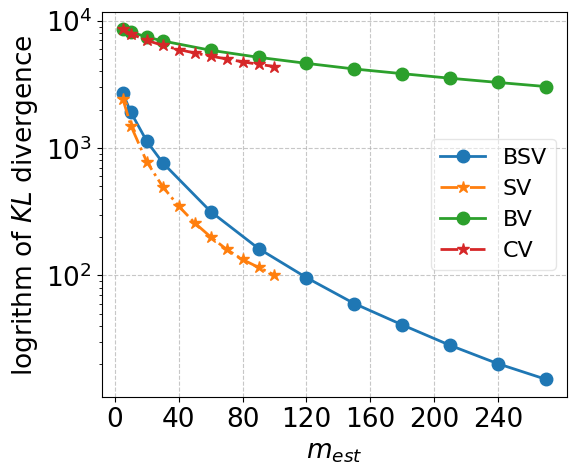

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 19})

# Reference log-likelihood from your previous calculation
reference_log_likelihood = 10207.434345472495

def extract_kl_divergence(log_files, reference_log_likelihood):
    data = []
    # Read each file and extract relevant information
    for file in log_files:
        df = pd.read_csv(file)
        
        # Extract m and isScaled from filename
        m = int(file.split('_m')[1].split('_')[0])
        is_scaled = int(file.split('isScaled')[1].split('_')[0])
        
        # Calculate KL divergence (difference in log-likelihood)
        kl_difference = reference_log_likelihood - df['optimized_log_likelihood'].values[0]
        
        data.append({
            'm': m,
            'KL': kl_difference,
            'is_scaled': 'Scaled' if is_scaled else 'Not Scaled'
        })
    return data

m_bv = (5, 10, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270)
m_cv = (5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)

# Read all log files
log_files_bv = [f'../../log/kl-matern72-simu/logFile_numPointsTotal5000_numBlocksTotal500_m{m}_seed0_isScaled{scale}_kl-matern72-simu.csv' for m in m_bv for scale in [0, 1]]
log_files_cv = [f'../../log/kl-matern72-simu/logFile_numPointsTotal5000_numBlocksTotal5000_m{m}_seed0_isScaled{scale}_kl-matern72-simu.csv' for m in m_cv for scale in [0, 1]]
# Create empty lists to store data
data_bv = []
data_cv = []

data_bv = extract_kl_divergence(log_files_bv, reference_log_likelihood)
data_cv = extract_kl_divergence(log_files_cv, reference_log_likelihood)

# Convert to DataFrame and sort by 'm'
df_plot_bv = pd.DataFrame(data_bv)
df_plot_cv = pd.DataFrame(data_cv)

# Create the plot
plt.figure(figsize=(6, 5))

# Define line styles for different scaling
markers = {'Scaled': 'o', 'Not Scaled': 's'}
colors = {'Scaled': 'red', 'Not Scaled': 'blue'}

# Plot lines for scaled and non-scaled data with markers
for scaled in ['Scaled', 'Not Scaled']:
    df_subset_bv = df_plot_bv[df_plot_bv['is_scaled'] == scaled].sort_values('m')  # Sort by 'm'
    df_subset_cv = df_plot_cv[df_plot_cv['is_scaled'] == scaled].sort_values('m')  # Sort by 'm'
    if scaled == "Scaled":
        scale_label = "S"
    else:
        scale_label = ""
    plt.plot(df_subset_bv['m'], df_subset_bv['KL'], 
             label= "B" + scale_label + "V",
             marker="o",  # Add markers to each point
             markersize=9,
             linestyle='-',  # Different line styles
            #  color=colors[scaled],
             linewidth=2)
    plt.plot(df_subset_cv['m'], df_subset_cv['KL'], 
             label= "SV" if scaled == "Scaled" else "CV",
             marker="*",  # Add markers to each point
             markersize=9,
             linestyle="-.",  # Different line styles
            #  color=colors[scaled],
             linewidth=2)

# plt.title('KL Divergence vs m')
plt.xlabel(r'$m_{est}$')
plt.ylabel(r'logrithm of $\mathit{KL}$ divergence')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(framealpha=0.5, fontsize=16)
plt.xticks(ticks=np.arange(0, max(m_bv)+1, 40))  

# Save the plot
os.makedirs('./fig', exist_ok=True)
plt.savefig('./fig/kl_divergence_comparison.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams.update({'font.size': 16})

m_bv_test = (5, 10, 20, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 500)
m_cv_test = (5, 10, 20, 30, 40, 50, 60, 70, 80)

# Read the CSV file
noScaled_path = '../../log/mspe-matern72-simu/logFile_numPointsTotal5000_numBlocksTotal500_m1_seed0_isScaled0_mspe-matern72-simu.csv'
df_no_scaled_bv = pd.read_csv(noScaled_path)
Scaled_path = '../../log/mspe-matern72-simu/logFile_numPointsTotal5000_numBlocksTotal500_m1_seed0_isScaled1_mspe-matern72-simu.csv'

# the first few rows are bv (size is equal to m_bv_test.size()) and rest is for cv , please split
df_scaled = pd.read_csv(Scaled_path)
df_scaled_cv = df_scaled.iloc[len(m_bv_test):].reset_index(drop=True)
df_scaled_bv = df_scaled.iloc[:len(m_bv_test)].reset_index(drop=True)
df_no_scaled = pd.read_csv(noScaled_path)
df_no_scaled_cv = df_no_scaled.iloc[len(m_bv_test):].reset_index(drop=True)
df_no_scaled_bv = df_no_scaled.iloc[:len(m_bv_test)].reset_index(drop=True)
# transform mspe to rmspe
# df_scaled_bv['mspe'] = np.sqrt(df_scaled_bv['mspe'])
# df_scaled_cv['mspe'] = np.sqrt(df_scaled_cv['mspe'])
# df_no_scaled_bv['mspe'] = np.sqrt(df_no_scaled_bv['mspe'])
# df_no_scaled_cv['mspe'] = np.sqrt(df_no_scaled_cv['mspe'])

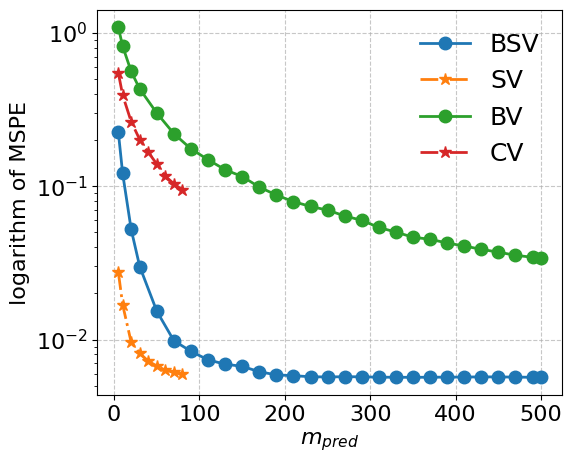

In [6]:
scale_factor = 1

# Create the plot
plt.figure(figsize=(6, 5))

# Define line styles for different scaling
markers = {'Scaled': 'o', 'Not Scaled': 's'}
colors = {'Scaled': 'red', 'Not Scaled': 'blue'}

plt.plot(m_bv_test, df_scaled_bv['mspe'] * scale_factor, 
             label="BSV",
             marker="o",  # Add markers to each point
             markersize=9,
             linestyle="-",  # Different line styles
            #  color=colors['Scaled'],
             linewidth=2)
plt.plot(m_cv_test, df_scaled_cv['mspe'] * scale_factor, 
             label="SV",
             marker="*",  # Add markers to each point
             markersize=9,
             linestyle="-.",  # Different line styles
            #  color=colors['Scaled'],
             linewidth=2)
plt.plot(m_bv_test, df_no_scaled_bv['mspe'] * scale_factor, 
             label="BV",
             marker="o",  # Add markers to each point
             markersize=9,
             linestyle='-',  # Different line styles
            #  color=colors['Not Scaled'],
             linewidth=2)
plt.plot(m_cv_test, df_no_scaled_cv['mspe'] * scale_factor, 
             label="CV",
             marker="*",  # Add markers to each point
             markersize=9,
             linestyle='-.',  # Different line styles
            #  color=colors['Not Scaled'],
             linewidth=2)

# plt.title('KL Divergence vs m')
plt.xlabel(r'$m_{pred}$')
plt.ylabel(r'logarithm of MSPE')
plt.yscale('log') 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(frameon=False, fontsize=18)

# Save the plot
os.makedirs('./fig', exist_ok=True)
plt.savefig('./fig/mspe_comparison.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
plt.rcParams.update({'font.size': 19})

# Reference log-likelihood from your previous calculation
reference_log_likelihood = 10207.434345472495

def extract_kl_divergence(ms, bcs, reference_log_likelihood):
    data = []
    # Read all log files
    # Read each file and extract relevant information
    for bc in bcs:
        m_kl = []
        for m in ms:
            file = f'../../log/kl-matern72-simu-bc-bs/logFile_numPointsTotal5000_numBlocksTotal{bc}_m{m}_seed0_isScaled1_kl-matern72-simu.csv'
            df = pd.read_csv(file)
            # Calculate KL divergence (difference in log-likelihood)
            kl_difference = reference_log_likelihood - df['optimized_log_likelihood'].values[0]
            m_kl.append(kl_difference)
        data.append(m_kl)
    return data

m_bv = (5, 10, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270)
m_bc = (100, 200, 400)

data_bv = extract_kl_divergence(m_bv, m_bc, reference_log_likelihood)

# Convert to DataFrame and sort by 'm'
df_plot_bv = pd.DataFrame(data_bv)
df_plot_bv

,0,1,2,3,4,5,6,7,8,9,10,11
0,2208.895848,1905.127155,1464.835026,1189.889524,702.711450,445.565006,297.035333,207.320888,154.340669,110.141986,89.153033,61.077378
1,2460.329254,1946.427323,1389.171206,1029.630649,509.384147,291.959660,178.283338,121.607131,85.251332,57.247925,41.436736,30.448073
2,2724.681079,1991.820935,1250.197162,857.801051,369.060397,191.918479,112.945098,73.774790,49.877483,34.014400,24.824437,18.705041


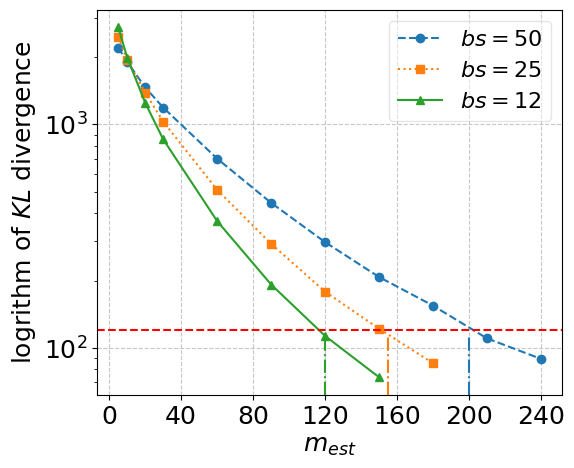

In [12]:
# Create the plot
plt.figure(figsize=(6, 5))

# Define different markers and linestyles for visual distinction
markers = ['o', 's', '^', 'D', 'v']  # circle, square, triangle up, diamond, triangle down
linestyles = ['--', ':', '-',  '-.', '-']  # solid, dashed, dotted, dashdot, solid
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf']

limted_num = [1, 3, 4]

# Plot each row (corresponding to different bc values)
for idx, bc in enumerate(m_bc):
    plt.plot(m_bv[:(len(m_bv) - limted_num[idx])], df_plot_bv.iloc[idx][:(len(m_bv) - limted_num[idx])], 
             marker=markers[idx], 
             color=colors[idx],
             label=f'$bs={int(5000/bc)}$', 
             linestyle=linestyles[idx])

plt.xlabel(r'$m_{est}$')
plt.ylabel(r'logrithm of $\mathit{KL}$ divergence')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(framealpha=0.5, fontsize=16)

plt.axhline(y=120, color='red', linestyle='--')
plt.axvline(x=120, color=colors[2], linestyle='-.', ymax = 0.15)
plt.axvline(x=155, color=colors[1], linestyle='-.', ymax = 0.15)
plt.axvline(x=200, color=colors[0], linestyle='-.', ymax = 0.15)

# Add this to make x-axis labels denser
plt.xticks(ticks=np.arange(0, max(m_bv)+1, 40))  

# Save the plot
os.makedirs('./fig', exist_ok=True)
plt.savefig('./fig/kl_divergence_bs_bc.pdf', bbox_inches='tight', dpi=300)
plt.show()

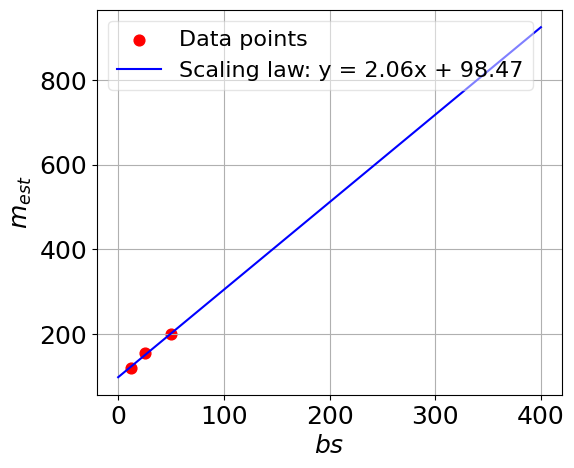

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.rcParams.update({'font.size': 18})

# Given points
x = np.array([12, 25, 50]).reshape(-1, 1)
y = np.array([120, 155, 200])

# Fit linear regression model
model = LinearRegression()
model.fit(x, y)

# Get slope and intercept
slope = model.coef_[0]
intercept = model.intercept_

# Create extended x values for plotting (from 0 to 400)
x_extended = np.linspace(0, 400, 1000).reshape(-1, 1)
y_extended = model.predict(x_extended)

# Plot the data points and the fitted line
plt.figure(figsize=(6, 5))
plt.scatter(x, y, color='red', marker='o', s=60, label='Data points')
plt.plot(x_extended, y_extended, color='blue', label=f'Scaling law: y = {slope:.2f}x + {intercept:.2f}')

# Add labels and title
plt.xlabel(r'$bs$')
plt.ylabel(r'$m_{est}$')
# plt.title('Linear Regression Fit with Extension to x=400')
plt.grid(True)
plt.legend(framealpha=0.5, fontsize=16)
plt.savefig('./fig/scaling_law_bs_mest.pdf', bbox_inches='tight', dpi=300)
# Show the plot
plt.show()

# # Print the equation of the line
# print(f"Scaling law: y = {slope:.4f}x + {intercept:.4f}")
# print(f"Value at x=400: y = {slope*400 + intercept:.2f}")